### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.1
2.6.3


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'), function=<function sum_over at 0x000002F7DCE80E50>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'), function=<function sum_over at 0x000002F7DCE80E50>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'), function=<function sum_over at 0x000002F7DCE80E50>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2'), function=<function sum_over at 0

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [10]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))

for dm in [0, 10]:
    for location in [2]:
        for switch in [0,1]:
            for ews_days in [0, 4]:
                pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": switch, "EWS_DaysToThreat": ews_days},
                                            name=f"Dike_{dm}dm_RfR_{location}{switch}_EWS_{ews_days}d"))


In [11]:
pol_list

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [12]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 15000
    with MultiprocessingEvaluator(dike_model, n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list, uncertainty_sampling=Samplers.LHS)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 15000 scenarios * 8 policies * 1 model(s) = 120000 experiments
100%|████████████████████████████████| 120000/120000 [3:23:34<00:00,  9.82it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [13]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
a = df.columns[df.columns.str.contains('Costs')]
df['Total Costs'] = df[a].sum(axis=1)

#df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
#df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Total Costs,policy
0,1.640288e+07,0.016509,6.126701e+08,0.730318,0.000000e+00,0.000000,4.830969e+06,0.002911,0.000000e+00,0.000000,0.0,0.000000,6.339040e+08,Policy_Dike_0dm_RfR_20_EWS_0d
1,3.056578e+09,1.978470,0.000000e+00,0.000000,0.000000e+00,0.000000,5.228778e+07,0.021473,4.724858e+08,0.371813,0.0,0.000000,3.581352e+09,Policy_Dike_0dm_RfR_20_EWS_0d
2,0.000000e+00,0.000000,2.131622e+07,0.018399,7.277446e+07,0.117079,8.589175e+07,0.035237,8.232292e+08,0.626235,0.0,0.000000,1.003212e+09,Policy_Dike_0dm_RfR_20_EWS_0d
3,3.498506e+09,1.968229,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,3.498506e+09,Policy_Dike_0dm_RfR_20_EWS_0d
4,2.847340e+09,1.979723,5.316239e+07,0.052730,1.602206e+09,2.828915,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,4.502708e+09,Policy_Dike_0dm_RfR_20_EWS_0d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2.893303e+09,0.236979,0.000000e+00,0.000000,4.421502e+07,0.000000,1.182268e+07,0.000609,0.000000e+00,0.000000,30700000.0,40134.689691,2.980081e+09,Policy_Dike_10dm_RfR_21_EWS_4d
119996,3.176503e+09,0.234739,6.059762e+06,0.000633,4.421502e+07,0.000000,0.000000e+00,0.000000,1.087318e+07,0.001109,30700000.0,39924.430286,3.268391e+09,Policy_Dike_10dm_RfR_21_EWS_4d
119997,3.206882e+09,0.237567,5.708215e+07,0.005839,4.421502e+07,0.000000,2.016471e+07,0.001041,0.000000e+00,0.000000,30700000.0,44213.549865,3.359088e+09,Policy_Dike_10dm_RfR_21_EWS_4d
119998,0.000000e+00,0.000000,1.029811e+07,0.001448,4.421502e+07,0.000000,6.746776e+07,0.004574,0.000000e+00,0.000000,30700000.0,7667.009496,1.526886e+08,Policy_Dike_10dm_RfR_21_EWS_4d


In [14]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [15]:
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [ ]:
from ema_workbench.analysis import (prim, dimensional_stacking)
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.0005)
box1 = prim_alg.find_box()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
dimensional_stacking.create_pivot_plot(x, y)
plt.show()

In [ ]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

KeyError: "Column(s) ['Cost plus Damage', 'Expected Annual Damage', 'Expected Number of Deaths'] do not exist"

In [ ]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

In [ ]:
TCA_df.columns

MultiIndex([('Expected Number of Deaths', 'mean'),
            ('Expected Number of Deaths',  'min'),
            ('Expected Number of Deaths',  'max'),
            ('Expected Number of Deaths',  'q05'),
            ('Expected Number of Deaths',  'q95'),
            (   'Expected Annual Damage', 'mean'),
            (   'Expected Annual Damage',  'min'),
            (   'Expected Annual Damage',  'max'),
            (   'Expected Annual Damage',  'q05'),
            (   'Expected Annual Damage',  'q95'),
            (              'Total Costs', 'mean'),
            (         'Cost plus Damage', 'mean'),
            (         'Cost plus Damage',  'min'),
            (         'Cost plus Damage',  'max'),
            (         'Cost plus Damage',  'q05'),
            (         'Cost plus Damage',  'q95')],
           )

### Plots

TODO: Make make some nice Seaborn plots?

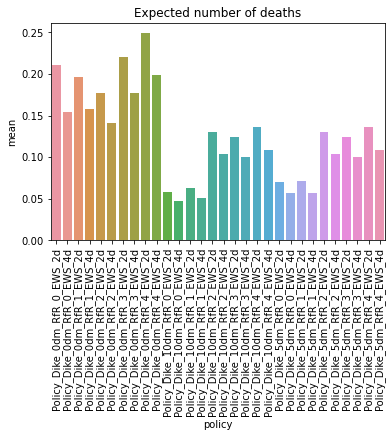

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Expected Number of Deaths"]["mean"].plot.bar()
ND = sns.barplot(x= TCA_df.index , y = TCA_df["Expected Number of Deaths"]["mean"], data = TCA_df)
ND.set(title='Expected number of deaths')
#ND.fig.suptitle('Expected number of deaths')
plt.xticks(rotation=90)
plt.show()
plt.savefig('number of deaths.png')

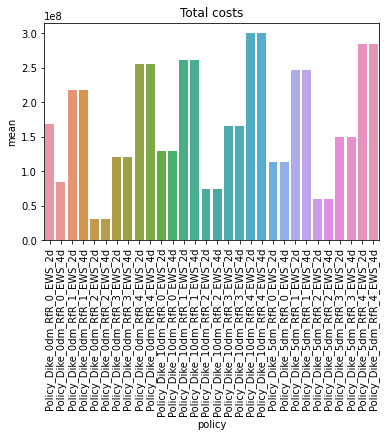

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Total Costs"]["mean"].plot.bar()
TC = sns.barplot(x= TCA_df.index , y = TCA_df["Total Costs"]["mean"], data = TCA_df)
TC.set(title='Total costs')
plt.xticks(rotation=90)
plt.show()
plt.savefig('total costs.png')

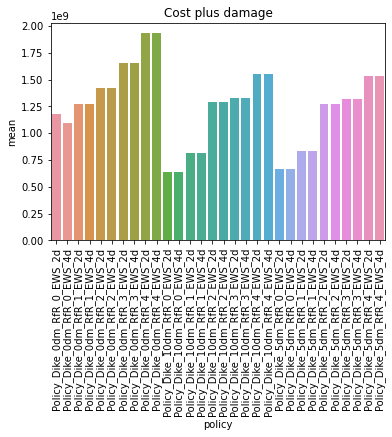

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Cost plus Damage"]["mean"].plot.bar()
CpD = sns.barplot(x= TCA_df.index , y = TCA_df["Cost plus Damage"]["mean"], data = TCA_df)
CpD.set(title='Cost plus damage')
plt.xticks(rotation=90)
plt.show()
plt.savefig('cost plus damage.png')